In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline
import os
from sqlalchemy import create_engine
import time
from datetime import datetime, date, time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import scipy.stats as st

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score

# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [2]:
# Repository of functions I've generated to use on the larger datasets in preparation of machine learning
def whatsleft(df): # useful for checking data clean-up status
    '''Functions like df.isnull().sum() except only shows the remaining columns with values missing'''
    nan_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
    print('Column \t\t # Nan Values')
    return df[nan_cols].isnull().sum()
# ex: whatsleft(flight10k)

def rem_outliers(df, col):
    ''' Remove outliers which fall outside of 3 standard deviations above and below the mean of the data set
            Input
                (0) dataframe containing the data
                (1) column to remove outliers from
            Output
                rows of df which are classified as outliers in the specified column are directly removed
                print out stating count of outliers removed '''
    mean, cutoff = np.mean(df[col]), np.std(df[col]) * 3   # 3 stddev outside the mean
    lower, upper = mean - cutoff, mean + cutoff
    outliers = [x for x in df[col] if x < lower or x > upper]
    df.drop(df[(df[col] > upper) | (df[col] < lower)].index, inplace=True)
    return f'{len(outliers)} outliers removed'
# ex: rem_outliers(flight10k, 'arr_delay')

def get_state(df, col, new_col):
    '''split the string of City, State text to grab only the end state code (2 letters) regardless of city name length
                Input:
                    (0) dataframe containing information
                    (1) col = column containing City, State Code information to pull state from
                    (2) name of the new column which will be appended to the end of the df
                Output:
                    df[new_col] containing state code only'''
    value=[]
    for i in df[col]:
        i = str(i)
        value.append(i[-2:])
    df[new_col] = value        
# ex: get_state(flight10k, 'origin_city_name', 'state_origin')

def fast(df):
    '''If the arrival delay time (minutes) is less than the departure delay, 
            then return 1 for 'fast' since the plane must have gone faster to make-up for the delayed departure
            else return 0 for 'not fast' as the arrival delay was as long or longer than departure delays'''
    if df['dep_delay'] > df['arr_delay']:
        return 1 # sped up during flight
    else: 
        return 0 # remained behind schedule
# ex: delays['fast'] = delays.apply(fast, 1)

def haul(df, col):
    '''Determine if flight length is SHORT, MEDIUM or LONG based on expected elapsed flight time. 
            Input 
            (0) df containing flight information, 
            (1) column containing the elapsed flight time in minutes
                  
            Output
            'haul_length' column determining haul length category per row in df'''
    length=[]
    for i in df[col]:
        if i < (3*60): # up to 3 hours
            length.append(0) # 0 = SHORT HAUL
        elif (i >= (3*60)) and (i < (6*60)): # 3-6 hours
            length.append(1) # 1 = MEDIUM HAUL
        elif i >= (6*60):# 6+ hours
            length.append(2) # 2 = LONG HAUL
    df['haul_length'] = length
# ex: haul(flight10k, 'crs_elapsed_time')
    
def gethour(df,col):
    '''Convert hhmm to hh (24-hr) hour-only output
            Input 
            (0) df containing flight information, 
            (1) column containing the hhmm time
                  
            Output
            rewrite on input column in rounded hh format'''
    values = []
    for i in df[col]:
        mins = (i % 100) / 60 
        hour = i // 100
        hh = round(hour+mins)
        values.append(hh)
    df[col] = values
# ex: gethour(flight10k, 'crs_dep_time')

def time_day(df, col):
    ''' Input:
            (0) df containing flight information
            (1) corresponding column of time of flight (i.e. departure or arrival) (format hhmm)
        Output:
            re-write of time column into categorical MORNING, AFTERNOON, EVENING, or OVERNIGHT'''
    gethour(df, col)
    timeday = []
    for i in df[col]:
        if (i>=23) or (i<5):
            timeday.append(0) # 0 = OVERNIGHT
        elif (i>=5) and (i<12):
            timeday.append(1) # 1 = MORNING
        elif (i>=12) and (i<18):
            timeday.append(2) # 2 = AFTERNOON
        elif (i>=18) and (i<23):
            timeday.append(3) # 3 = EVENING
    return timeday
# ex: time_day(flight10k, 'crs_dep_time')

# UPDATED C - need same as below, a pre-defined listing of the airports on these lists so we can model unknown with it
def busiest_airports(flight_df, airport_col):
    ''' Input:
            (0) dataframe of flight information
            (1) corresponding column containing airport codes (i.e. origin or destination)
        Output 
            new column of airport ranking of business <-- get this into csv file
                0 - not busy airports
                1 - slightly busy
                2 - moderately busy
                3 - busy
                4 - top ~10 heavy air traffic airports '''
    # step one, new df containing airport code and count of flights -- grabbing only top10
    df = pd.DataFrame(flight_df[airport_col].value_counts()).reset_index().rename(columns={'index':'airport',airport_col:'count'})
    # step two, calculate percentage of total air traffic for each airport -- don't want to make cut offs as numbers but percentage of air traffic
    perc_list = []
    for x in df['count']:
        perc_list.append((x / flight_df[airport_col].count()) * 100)
    df['p_airtraffic'] = perc_list
    df.drop(columns='count', inplace=True)
    busy_dict = {}
    for i,j in zip(df['airport'],df['p_airtraffic']):
        if j < 0.012:
            busy_dict[i] = 0 # bottom 25% of airports 'not busy'
        elif (j>=0.012) and (j<0.04):
            busy_dict[i] = 1 # 50% range of airports 'slight busy'
        elif (j>=0.04) and (j<0.152):
            busy_dict[i] = 2 # 75% range of airports 'moderately busy'
        elif (j>=0.152) and (j<2.2):
            busy_dict[i] = 3 # up to top ~10 airports 'busy'
        elif (j>=2.2):
            busy_dict[i] = 4 #  top ~10 of airports 'heavy air traffic'
    #flight_df[f'busy_{airport_col}'] = np.nan
    #flight_df[f'busy_{airport_col}'] = flight_df[f'busy_{airport_col}'].fillna(flight_df[airport_col].map(busy_dict))
# ex: busiest_airports(flights,'origin')
    return busy_dict
def busy_rating(df, airport_col):
    traffic_rating = pd.DataFrame.from_dict(busiest_airports(df, airport_col), orient='index', columns=[f'busy_{airport_col}']).reset_index().rename(columns={'index':f'{airport_col}'})
    traffic_rating.to_csv(f'data/{airport_col}_traffic_rating.csv')
# ex: busy_rating(flights, 'origin')

# UPDATED A - this outputs the dictionary which was saved as csv for all future data use
def airline_delay(df, dep_delay, airline_col):
    ''' function which looks at the average dep_delay for each airline and gives ranking of expected delay based on airline'''
    stats = pd.DataFrame(df[dep_delay].groupby(df[airline_col]).mean()).sort_values(dep_delay, ascending=False).reset_index()
    rating = {}
    for i,j in zip(stats[airline_col], stats[dep_delay]):
        if (j < 3):
            rating[i] = 0 # no delays on average (~25% q1 of means)
        elif (j >= 3) and (j < 6):
            rating[i] = 1 # low delays on average (~50% q2 of means)
        elif (j >= 6) and (j < 9):
            rating[i] = 2 # medium delays on average (~75% q3 of means)
        elif (j >= 9):
            rating[i] = 3 # high delays on average (>75% q3 of means)
    #df['airline_delay'] = np.nan
    #df['airline_delay'] = df['airline_delay'].fillna(df[airline_col].map(rating))            
# ex: airline_delay(flight10k, 'dep_delay', 'op_unique_carrier')
    return rating


In [ ]:
# code to generate the data for 2018-2019 information can be found in Database_Exploration

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

LOGIC: after we generate all the different model types, how will we produce an end result? ENSEMBLING [Source](https://towardsdatascience.com/two-is-better-than-one-ensembling-models-611ee4fa9bd8)

In [ ]:
from sklearn.ensemble import VotingClassifier
ensemble=VotingClassifier(estimators=[('Decision Tree', decisiontree), ('Random Forest', forest)], 
                       voting='soft', weights=[2,1]).fit(train_X,train_Y)
print('The accuracy for DecisionTree and Random Forest is:',ensemble.score(test_X,test_Y))
# We can assign weights depending on the performance or take an average, ie setting equal weights for the algorithms.
# Bag, Boost or Stack algorithms to combine!

### Data Cleaning of the 250K Data Sample

In [14]:
passengers = pd.read_csv('data/passengers250K.csv', index_col=0)
flights = pd.read_csv('data/flights250K.csv', index_col=0)

# remove empty flanking column
flights.drop(columns='no_name', inplace=True)
# if flight cancelled, remove from dataset since we want to prdecit flights that ARE leaving
flights = flights[flights['cancelled'] == 0] # 0 meaning not cancelled
flights.drop(columns=['cancelled','cancellation_code'], inplace=True)
# time count columns NaN to be filled with 0 since no time elapsed
time_counts = ['dep_delay','arr_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay','total_add_gtime','longest_add_gtime','taxi_out','taxi_in']
flights[time_counts] = flights[time_counts].fillna(0)
# filling remaining empty NaN time columns with related columns information (i.e. wheels_off == dep_time/wheels_on == arr_time/actual_elapsed_time == CRS_elapsed_time) plotted earlier
flights['wheels_off'] = flights['wheels_off'].fillna(flights['crs_dep_time'])
flights['wheels_on'] = flights['wheels_on'].fillna(flights['crs_arr_time'])
flights['arr_time'] = flights['arr_time'].fillna(flights['crs_arr_time'])
flights['actual_elapsed_time'] = flights['actual_elapsed_time'].fillna(flights['crs_elapsed_time'])
flights['air_time'] = flights['air_time'].fillna(flights['crs_elapsed_time'])
# 9778 / 9855 empty =  99+% NaN -- let's drop this first_dep_time column
flights.drop(columns='first_dep_time', inplace=True)
# THIS CAN BE CHANGED
#columns never used to drop
flights.drop(columns=['mkt_unique_carrier','tail_num','branded_code_share','mkt_carrier','mkt_carrier_fl_num','op_carrier_fl_num','origin_airport_id','dest_airport_id','diverted','dup','flights','origin_city_name','dest_city_name'],inplace=True)

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [4]:
flights.head(1)

,fl_date,airline,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,total_add_gtime,longest_add_gtime
0,2018-12-26,OO,OKC,SLC,839,830.0,-9.0,15.0,845.0,945.0,25.0,1028,1010.0,-18.0,169.0,160.0,120.0,866.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# remove outliers to 3stdev of arrival delay mean to avoid skewed data in the model
rem_outliers(flights, 'arr_delay')

# convert date to datetime in order to grab the month
flights['fl_date'] = pd.to_datetime(flights['fl_date'])
flights['fl_month'] = flights['fl_date'].dt.month
flights.drop(columns='fl_date', inplace=True) # this won't be needed after we get month

# set delay rating based on expected performance of the airline
airline_rating = pd.read_csv('data/airline_delay_rating.csv',index_col=0)
flights = flights.merge(airline_rating, left_on='op_unique_carrier', right_on='airline', how='inner')
flights.drop(columns=['op_unique_carrier'],inplace=True) 
# drop airlines since we are calculating delay level based on their mean late carrier info

# obtain haul length of the flight
haul(flights, 'crs_elapsed_time')
# drop columns relating to mins of flight now that we have categories for length
flights.drop(columns=['crs_elapsed_time','actual_elapsed_time','air_time'],inplace=True)

# drop more columns we will not have in the prediction
flights.drop(columns=['taxi_out','taxi_in','arr_time','dep_delay','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay','total_add_gtime','longest_add_gtime'], inplace=True)

# new column of categorical time of day information
flights['dep_timeday'] = time_day(flights, 'crs_dep_time')
flights['arr_timeday'] = time_day(flights, 'crs_arr_time')
# drop info relating to time of day hhmm since we now have time of day categories for dep and arrival
flights.drop(columns=['crs_dep_time','dep_time','wheels_off','wheels_on','crs_arr_time'],inplace=True)

# classify the business of the origin and departure airports
origin_traffic = pd.read_csv('data/origin_traffic_rating.csv', index_col=0)
flights = flights.merge(origin_traffic, left_on='origin', right_on='origin', how='left')
dest_traffic = pd.read_csv('data/dest_traffic_rating.csv', index_col=0)
flights = flights.merge(dest_traffic, left_on='dest', right_on='dest', how='left')

flights.drop(columns='airline',inplace=True) 
flights.drop(columns=['origin','dest'],inplace=True)

# have a look at the dataset
flights.head()
flights.shape
flights.to_csv('data/flights250k_cleaned.csv')
# new functions
#airline_rating = pd.DataFrame.from_dict(airline_delay(flights, 'dep_delay', 'airline'), orient='index', columns=['airline_delay']).reset_index().rename(columns={'index':'airline'})
#airline_rating.to_csv('data/airline_delay_rating.csv')
#busy_rating(flights, 'origin')
#busy_rating(flights, 'dest')
# pulled these down from above to allow me to run new functions



'3921 outliers removed'

,arr_delay,distance,fl_month,airline_delay,haul_length,dep_timeday,arr_timeday,busy_origin,busy_dest
0,-18.0,866.0,12,1,0,1,1,3,3
1,-6.0,284.0,3,1,0,1,1,1,3
2,-13.0,649.0,12,1,0,3,3,3,4
3,-19.0,588.0,3,1,0,2,2,3,3
4,3.0,893.0,10,1,0,3,0,4,2


(241793, 9)

In [3]:
flights = pd.read_csv('data/flights250k_cleaned.csv', index_col=0)
flights.head()
flights.shape

,arr_delay,distance,fl_month,airline_delay,haul_length,dep_timeday,arr_timeday,busy_origin,busy_dest
0,-18.0,866.0,12,1,0,1,1,3,3
1,-6.0,284.0,3,1,0,1,1,1,3
2,-13.0,649.0,12,1,0,3,3,3,4
3,-19.0,588.0,3,1,0,2,2,3,3
4,3.0,893.0,10,1,0,3,0,4,2


(241793, 9)

Data Scaling

In [4]:
X = flights.drop(columns=['arr_delay'])
y = flights['arr_delay']
rob_sc = RobustScaler()
X_sc = rob_sc.fit_transform(X)

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.2, random_state=42)

- PCA components?

In [6]:
pca = PCA(random_state = 42)
pca.fit_transform(X)
eigenvalues = pca.explained_variance_
k = 0
for val in eigenvalues:
    if val > 1:
        k += 1
k

array([[ 9.55475262e+01, -5.41267690e+00,  1.14449916e+00, ...,
         3.13594698e-02,  1.44604544e-01, -2.82883470e-01],
       [-4.86452683e+02,  3.58925480e+00,  1.27747777e+00, ...,
         5.02443375e-01,  1.31939120e+00,  2.50263536e-02],
       [-1.21452407e+02, -5.40819480e+00, -1.58346101e+00, ...,
         5.25132727e-01, -6.27264268e-01, -1.49515667e-01],
       ...,
       [ 2.15471223e+01, -1.40993424e+00, -1.45229307e+00, ...,
         7.50332971e-01,  2.59605695e+00, -2.89151796e-01],
       [ 2.15472738e+01,  5.87810733e-01,  2.66589399e-01, ...,
        -1.23669487e+00,  2.83922993e+00, -2.19231685e-01],
       [ 2.15472030e+01,  2.58852297e+00, -3.06561914e-01, ...,
        -4.81769096e-01,  2.78908454e+00, -2.20223888e-01]])

3

In [7]:
pca = PCA(n_components = k, random_state = 42)
X_pca = pca.fit_transform(X)
Xpca_train, Xpca_test, ypca_train, ypca_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [9]:
classifiers = {
    "Linear Regression": LinearRegression(),
    "Logisitic Regression": LogisticRegression(),
    "Support Vector Regression": SVR(),
    "Random Forest Regression": RandomForestRegressor(),
    "Gaussian Naive Bayes": GaussianNB(),
    "XGBoost": xgb
}

Linear Regression
Original Features

In [24]:
%%time
# Linear Regression on Original Features
lin_params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lin = GridSearchCV(LinearRegression(), lin_params, cv=5, verbose=1, n_jobs=-1)
grid_lin.fit(X_train, y_train)
linreg = grid_lin.best_estimator_

linreg_score = cross_val_score(linreg, X_train, y_train, cv=5)
print('Cross Validation Score: ', round(linreg_score.mean() * 100, 2).astype(str) + '%')
print("training R2 / Variance: ", round(grid_lin.best_score_,2))
print(f"Residual Sum of Squares: {round(np.mean((grid_lin.predict(X_test) - y_test) ** 2),2)}")

y_linreg = linreg.predict(X_test)
print('\nLinear Regression - y_test')
print('R2 Score \t{:.2f}'.format(metrics.r2_score(y_test, y_linreg)))
print('Test RMSE \t{:.2f}'.format(metrics.mean_squared_error(y_test, y_linreg)))
print('Test MAE \t{:.2f}\n'.format(metrics.mean_absolute_error(y_test, y_linreg)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Cross Validation Score:  1.86%
training R2 / Variance:  0.02
Residual Sum of Squares: 786.24

Linear Regression - y_test
R2 Score 	0.02
Test RMSE 	786.24
Test MAE 	18.63

CPU times: user 1.05 s, sys: 1 s, total: 2.05 s
Wall time: 2.08 s


Linear Regression PCA Components

In [23]:
%%time
# Linear Regression on PCA Components
lin_params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linp = GridSearchCV(LinearRegression(), lin_params, cv=5, verbose=1, n_jobs=-1)
grid_linp.fit(Xpca_train, ypca_train)
plinreg = grid_linp.best_estimator_

plinreg_score = cross_val_score(plinreg, Xpca_train, ypca_train, cv=5)
print('Cross Validation Score: ', round(plinreg_score.mean() * 100, 2).astype(str) + '%')
print("Training R2 / Variance: ", round(grid_linp.best_score_,2))
print(f"Residual Sum of Squares (RSS): {round(np.mean((grid_linp.predict(Xpca_test) - ypca_test) ** 2),2)}")

ypca_linreg = plinreg.predict(Xpca_test)
print('\nLinear Regression - ypca_test')
print('R2 Score \t{:.2f}'.format(metrics.r2_score(ypca_test, ypca_linreg)))
print('RMSE Score \t{:.2f}'.format(metrics.mean_squared_error(ypca_test, ypca_linreg)))
print('MAE Score \t{:.2f}\n'.format(metrics.mean_absolute_error(ypca_test, ypca_linreg)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Cross Validation Score:  1.07%
Training R2 / Variance:  0.01
Residual Sum of Squares (RSS): 793.42

Linear Regression - ypca_test
R2 Score 	0.01
RMSE Score 	793.42
MAE Score 	18.70

CPU times: user 547 ms, sys: 750 ms, total: 1.3 s
Wall time: 1.19 s


Logistic Regression Original Features

In [8]:
%%time
# Logistic Regression 
log_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log = GridSearchCV(LogisticRegression(), log_params, cv=3)
grid_log.fit(X_train, y_train)
logreg = grid_log.best_estimator_
logreg_score = cross_val_score(logreg, X_train, y_train, cv=3, verbose=1, njobs=-1)
print('Logistic Regression Cross Validation Score: ', round(logreg_score.mean() * 100, 2).astype(str) + '%')
print("Training R2 / Variance: ", round(grid_log.best_score_,2))
print(f"Residual sum of squares: {round(np.mean((grid_log.predict(X_test) - y_test) ** 2),2)}")

y_logreg = logreg.predict(X_test)
print('\nLogistic Regression - y_test')
print('Test R2 Score \t{:.2f}\n'.format(metrics.r2_score(y_test, y_logreg)))

Logistic Regression PCA Components

In [ ]:
%%time
# Logistic Regression 
log_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_logp = GridSearchCV(LogisticRegression(), log_params, cv=5)
grid_logp.fit(Xpca_train, ypca_train)
plogreg = grid_logp.best_estimator_
plogreg_score = cross_val_score(plogreg, Xpca_train, ypca_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(plogreg_score.mean() * 100, 2).astype(str) + '%')
print("Training R2 / Variance: ", round(grid_logp.best_score_,2))
print(f"Residual sum of squares: {round(np.mean((grid_logp.predict(Xpca_test) - ypca_test) ** 2),2)}")

ypca_logreg = plogreg.predict(Xpca_test)
print('\nLogistic Regression - ypca_test')
print('Test R2 Score \t{:.2f}\n'.format(metrics.r2_score(ypca_test, ypca_logreg)))

Gaussian Naive Bayes Original Features

Gaussian Naive Bayes PCA Components

Random Forest Original Features

In [12]:
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
%%time
tree_params = {"n_estimators": [100, 250, 500, 750, 1000],
               'max_depth': [int(x) for x in np.linspace(1, 32, num = 5)]}
grid_tree = GridSearchCV(RandomForestRegressor(), tree_params, cv=3, verbose=1)
grid_tree.fit(X_train, y_train)
forest = grid_tree.best_estimator_
forest_score = cross_val_score(forest, X_train, y_train, cv=3)
print('Random Forest Regressor Cross Validation Score: ', round(forest_score.mean() * 100, 2).astype(str) + '%')
print("Training R2 / Variance: ", round(grid_tree.best_score_,2))
print(f"Residual Sum of Squares (RSS): {round(np.mean((grid_tree.predict(X_test) - y_test) ** 2),2)}")

y_forest = forest.predict(X_test)
print('\nRandom Forest Regressor - y_test')
print('Test R2 Score \t{:.2f}'.format(metrics.r2_score(y_test, y_forest)))
print('Test RMSE \t{:.2f}'.format(metrics.mean_squared_error(y_test, y_forest)))
print('Test MAE \t{:.2f}\n'.format(metrics.mean_absolute_error(y_test, y_forest)))

Fitting 3 folds for each of 25 candidates, totalling 75 fits


Random Forest PCA Components

In [10]:
%%time
tree_params = {"n_estimators": [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
               'max_depth': [int(x) for x in np.linspace(10, 100, num = 10)]}
grid_ptree = GridSearchCV(RandomForestRegressor(), tree_params, cv=3, verbose=1, n_jobs=-1)
grid_ptree.fit(Xpca_train, ypca_train)
pforest = grid_ptree.best_estimator_
pforest_score = cross_val_score(pforest, Xpca_train, ypca_train, cv=3)
print('Random Forest Regressor Cross Validation Score: ', round(pforest_score.mean() * 100, 2).astype(str) + '%')
print("Training R2 / Variance: ", round(grid_ptree.best_score_,2))
print(f"Residual Sum of Squares (RSS): {round(np.mean((grid_ptree.predict(Xpca_test) - ypca_test) ** 2),2)}")

y_pforest = pforest.predict(Xpca_test)
print('\nRandom Forest Regressor - ypca_test')
print('Test R2 Score \t{:.2f}\n'.format(metrics.r2_score(ypca_test, y_pforest)))

TypeError: __init__() got an unexpected keyword argument 'njobs'

SVM Original Features

In [14]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [ ]:
%%time
svr_params = {'kernel': ['linear','rbf','poly','sigmoid'],
              'C': [1, 5, 10],
              'gamma': [0.0000001, 0.00001, 0.001, 0.1, 1],
              'epsilon': [0.1, 0.2, 0.3, 0.5, ]
             }
grid_svr = GridSearchCV(SVR(), svr_params, cv=3, verbose=2, n_jobs=-1)
grid_svr.fit(X_train, y_train)
svr = grid_svr.best_estimator_
svr_score = cross_val_score(svr, X_train, y_train, cv=3)
print('Support Vector Regressor (SVR) Cross Validation Score: ', round(svr_score.mean() * 100, 2).astype(str) + '%')
print("Training R2 / Variance: ", round(grid_svr.best_score_,2))
print(f"Residual Sum of Squares (RSS): {round(np.mean((grid_svr.predict(X_test) - y_test) ** 2),2)}")

y_svr = svr.predict(X_test)
print('\nSupport Vector Regressor (SVR) - y_test')
print('Test R2 Score \t{:.2f}\n'.format(metrics.r2_score(y_test, y_forest)))

SVM PCA Components

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

{'C': 0.1, 'penalty': 'l2'}

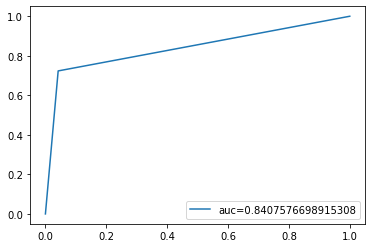

In [76]:
y_pred = best_model.predict(X_test)
auc = metrics.roc_auc_score(y_test, y_pred, multi_class='ovr')
fpr, tpr, threshold = metrics.roc_curve(y_test,  y_pred)

plt.plot(fpr,tpr,label="auc="+str(auc));
plt.legend(loc=4);
plt.show();

In [83]:
print('Log Class Results')
print('Recall \t\t{:.2f}'.format(metrics.recall_score(y_test, y_pred)))
print('Precision \t{:.2f}'.format(metrics.precision_score(y_test, y_pred)))
print('F1 Score \t{:.2f}'.format(metrics.f1_score(y_test, y_pred)))
print('Accuracy \t{:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('R2 Score \t{:.2f}'.format(metrics.r2_score(y_test, y_pred)))

Log Reg Results
Recall 		0.72
Precision 	0.90
F1 Score 	0.80
Accuracy 	0.88
R2 Score 	0.46


### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

In [36]:
flight_test = pd.read_csv('data/flighttest.csv', index_col=0)
#flight_test.head()
flight_test.shape
#whatsleft(flight_test)

(660556, 20)

Data Cleaning mimicked from above, adjusted where appropriate

In [37]:
# only NaN-contianing column is tail_num which is to be dropped anyways

#columns never used to drop
flight_test.drop(columns=['mkt_unique_carrier','tail_num','branded_code_share','mkt_carrier','mkt_carrier_fl_num','op_carrier_fl_num','origin_airport_id','dest_airport_id','dup','flights','origin_city_name','dest_city_name'],inplace=True)

# convert date to datetime in order to grab the month
flight_test['fl_date'] = pd.to_datetime(flight_test['fl_date'])
flight_test['fl_month'] = flight_test['fl_date'].dt.month
flight_test.drop(columns='fl_date', inplace=True) # this won't be needed after we get month

# set delay rating based on expected performance of the airline
flight_test = flight_test.merge(airline_rating, left_on='op_unique_carrier', right_on='airline', how='inner')
flight_test.drop(columns=['op_unique_carrier','airline'],inplace=True) 

# obtain haul length of the flight
haul(flight_test, 'crs_elapsed_time')
flight_test.drop(columns=['crs_elapsed_time'],inplace=True)

# new column of categorical time of day information
flight_test['dep_timeday'] = time_day(flight_test, 'crs_dep_time')
flight_test['arr_timeday'] = time_day(flight_test, 'crs_arr_time')
flight_test.drop(columns=['crs_dep_time','crs_arr_time'],inplace=True)

# classify the business of the origin and departure airports
flight_test = flight_test.merge(origin_traffic, left_on='origin', right_on='origin', how='left')
flight_test = flight_test.merge(dest_traffic, left_on='dest', right_on='dest', how='left')
flight_test = flight_test.fillna(flight_test['busy_origin'].mean())
#flight_test = flight_test['busy_dest'].fillna(flight_test['busy_dest'].mean())
flight_test.drop(columns=['origin','dest'],inplace=True)

# have a look at the dataset
flight_test.head()
flight_test.shape

,distance,fl_month,airline_delay,haul_length,dep_timeday,arr_timeday,busy_origin,busy_dest
0,363,1,2,0,3,3,3.0,4.0
1,363,1,2,0,2,2,3.0,4.0
2,333,1,2,0,3,3,3.0,3.0
3,333,1,2,0,2,2,3.0,3.0
4,333,1,2,0,1,1,3.0,3.0


(660556, 8)

In [38]:
whatsleft(flight_test)

Column 		 # Nan Values


Series([], dtype: float64)

In [29]:
%%time
# Linear Regression on Original Features
lin_params = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_lin = GridSearchCV(LinearRegression(), lin_params, cv=5)
grid_lin.fit(X_sc, y)
linreg = grid_lin.best_estimator_

CPU times: user 2.25 s, sys: 2.27 s, total: 4.52 s
Wall time: 1.17 s


In [39]:
linreg_score = cross_val_score(linreg, X_sc, y, cv=5)
print('Linear Regression Cross Validation Score: ', round(linreg_score.mean() * 100, 2).astype(str) + '%')
print("Training R2 / Variance: ", grid_lin.best_score_)
print(f"Residual Sum of Squares: {round(np.mean((grid_lin.predict(X_sc) - y) ** 2),2)}")
y_pred = linreg.predict(flight_test)
print('Linear Regression - y_test')
print('Test R2 Score \t{:.2f}'.format(metrics.r2_score(y, y_pred)))

Linear Regression Cross Validation Score:  1.47%
Training R2 / Variance:  0.01548138243857818
Residual Sum of Squares: 789.88
Linear Regression - y_test


ValueError: Found input variables with inconsistent numbers of samples: [241793, 660556]

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.